# The Sims-Flanagan high-fidelity trajectory leg

The Sims-Flanagan trajectory leg {cite:p}`sims` is implemented in `pykep` in the class {class}`pykep.leg.sims_flanagan_hf`. The leg can be used to describe a low-thrust leg with low-fidelity as it assumes Keplerian dynamics
and approximates the continuous thrust via a sequence of continuous, constant thrust arcs (zero-hold). The leg is defined by a starting position $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, an arrival position $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time of flight $T$.

A sequence of throttles $\mathbf u = [u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, u_{x2}, u_{y2}, u_{z2}, ... ]$ define the direction and magnitude of the continuous throttle vector along each segment (i.e. trajectory parts of equal temporal length $\frac Tn$).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.sims_flanagan_hf` efficiently.

We start with some imports:

In [378]:
import pykep as pk
import numpy as np
import time
import pygmo as pg

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

We then define the spacecraft propulsion system and the initial and final state. In this case they are not related to any orbital mechanics and are chosen arbitrarily for the purpose of demostrating the API.

In [379]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000
veff = isp * pk.G0

# Initial state
ms = 1500.0
rs = np.array([1, 0.1, -0.1]) * pk.AU
vs = np.array([0.2, 1, -0.2]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([-1.2, -0.1, 0.1]) * pk.AU
vf = np.array([0.2, -1.023, 0.44]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 4
cut = 0.6
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
alphas = np.random.uniform(0, 1, size=(nseg))

tof = 324.0 * pk.DAY2SEC

Non-dimensionalise the dynamics

In [380]:
# L, TIME, VEL, ACC, MASS = 1, 1, 1, 1, 1

In [381]:
# Normalise
L = pk.AU
TIME = np.sqrt(L**3 / mu)
VEL = L / TIME
ACC = VEL / TIME
MASS = ms

print(f'Normalise L {L:.4f} T {TIME:.4f} V {VEL:.4f} M {MASS:.4f}')

# Problem data
mu = mu / (L**3 / TIME**2)
max_thrust = max_thrust / (MASS * L / TIME**2)
veff = veff / VEL

# Initial state
ms = ms / MASS
rs = rs / L
vs = vs / VEL

# Final state
mf = mf / MASS
rf = rf / L
vf = vf / VEL

# tof
tof = tof / TIME

Normalise L 149597870700.0000 T 5022642.8909 V 29784.6918 M 1500.0000


Initialise a taylor adaptive integrator

In [382]:
ta = pk.ta.get_zero_hold_kep(1e-16)
ta_var = pk.ta.get_zero_hold_kep_var(1e-16)

Decode Alphas

In [383]:
# Decode alphas to direct
talphas = pk.alpha2direct(alphas, tof)

In [384]:
throttles

array([-0.43374835,  0.98907021,  0.70689949, -0.91831545,  0.22831371,
        0.71742168,  0.9800872 ,  0.6343788 ,  0.80534894, -0.24560035,
        0.03134003, -0.13393601])

In [385]:
talphas

[0.19617579849893405,
 1.6242067976700936,
 2.271338019512882,
 1.4817594441042312]

Now we instantiate the leg:

In [386]:
# We are now ready to instantiate a leg
sf = pk.leg.sims_flanagan_hf(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    veff=veff,
    mu=mu,
    cut=cut,
    tas=(ta,ta_var),
)

sf_alpha = pk.leg.sims_flanagan_hf_alpha(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    talphas=talphas,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    veff=veff,
    mu=mu,
    cut=cut,
    tas=(ta,ta_var),
)

And plot the trajectory represented by the random sequence of throttles.

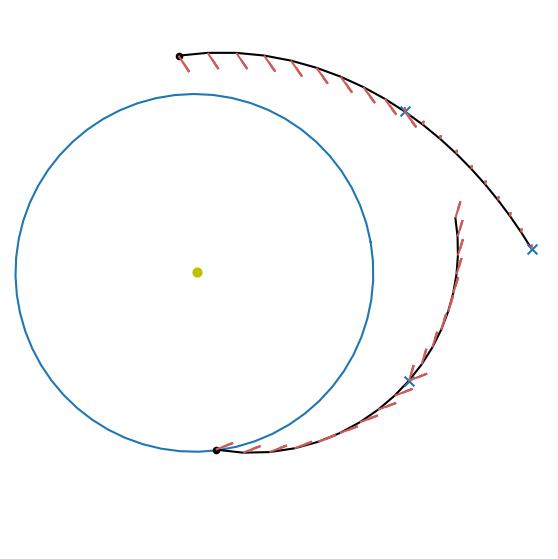

In [387]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0] * L / pk.AU, rs[1] * L / pk.AU, rs[2] * L / pk.AU, c="k", s=20)
ax.scatter(rf[0] * L / pk.AU, rf[1] * L / pk.AU, rf[2] * L / pk.AU, c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf, units=pk.AU, N=10, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5,
    unit_L=L, unit_T=TIME, unit_M=MASS,
)


# Making the axis nicer
D=1
ax.set_xlim(-D,D)
ax.set_ylim(-D/2,D*3/2)
ax.view_init(90,0)
ax.axis('off');

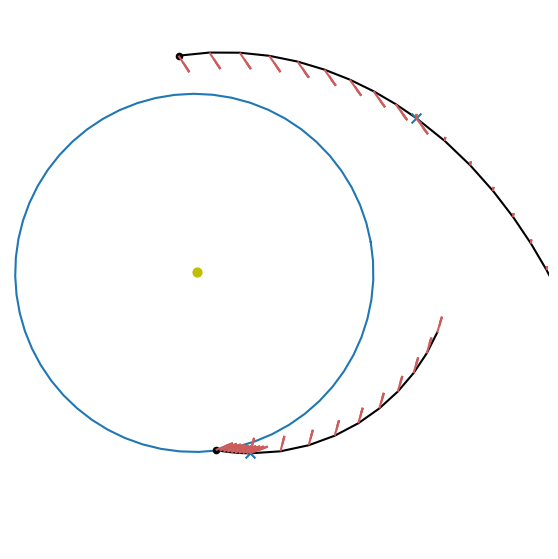

In [388]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0] * L / pk.AU, rs[1] * L / pk.AU, rs[2] * L / pk.AU, c="k", s=20)
ax.scatter(rf[0] * L / pk.AU, rf[1] * L / pk.AU, rf[2] * L / pk.AU, c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf_alpha, units=pk.AU, N=10, use_alpha = True, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5,
    unit_L=L, unit_T=TIME, unit_M=MASS,
)


# Making the axis nicer
D=1
ax.set_xlim(-D,D)
ax.set_ylim(-D/2,D*3/2)
ax.view_init(90,0)
ax.axis('off');

# Now for the CR3BP

In [389]:
# Problem data
mu = pk.MU_MOON / (pk.MU_EARTH + pk.MU_MOON)
max_thrust = 0.1
isp = 3000
veff = isp * pk.G0

# Initial state
ms = 1500.0
rs = np.array([1.0809931218390707,0.0,-0.20235953267405354])
vs = np.array([0.0,-0.19895001215078018,0.0])

# Final state
mf = 1300.0
rf = np.array([1.1648780946517576,0.0,-0.11145303634437023])
vf = np.array([0.0,-0.20191923237095796,0.0])

# Throttles and tof
nseg = 10
cut = 0.6
throttles = np.random.uniform(-1, 1, size=(nseg * 3))/10
alphas = np.random.uniform(0, 1, size=(nseg))

tof = 30 * pk.DAY2SEC

Non-dimensionalise

In [390]:
# Normalise
L = 384400e3
TIME = np.sqrt(L**3 / (pk.MU_EARTH+pk.MU_MOON))
VEL = L / TIME
ACC = VEL / TIME
MASS = ms

print(f'Normalise L {L:.4f} T {TIME:.4f} V {VEL:.4f} M {MASS:.4f}')

# Problem data
# mu already in non-dimensional units
max_thrust = max_thrust / (MASS * L / TIME**2)
veff = veff / VEL

# Initial state
ms = ms / MASS
# rs already in non-dimensional units
# vs already in non-dimensional units

# Final state
mf = mf / MASS
# rf already in non-dimensional units
# vf already in non-dimensional units

# tof
tof = tof / TIME

Normalise L 384400000.0000 T 375190.2619 V 1024.5468 M 1500.0000


Decode Alphas

In [391]:
# Decode alphas to direct
talphas = pk.alpha2direct(alphas, tof)

Initialise the taylor adaptive integrator

In [392]:
ta = pk.ta.get_zero_hold_cr3bp(1e-16)
ta_var = pk.ta.get_zero_hold_cr3bp_var(1e-16)

Now we instantiate the leg

In [394]:
# We are now ready to instantiate a leg
sf = pk.leg.sims_flanagan_hf(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    veff=veff,
    mu=mu,
    cut=cut,
    tas=(ta,ta_var),
)

# We are now ready to instantiate a leg
sf_alpha = pk.leg.sims_flanagan_hf_alpha(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    talphas=talphas,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    veff=veff,
    mu=mu,
    cut=cut,
    tas=(ta,ta_var),
)

And plot the trajectory represented by the random sequence of throttles.

(-0.5, 0.5)

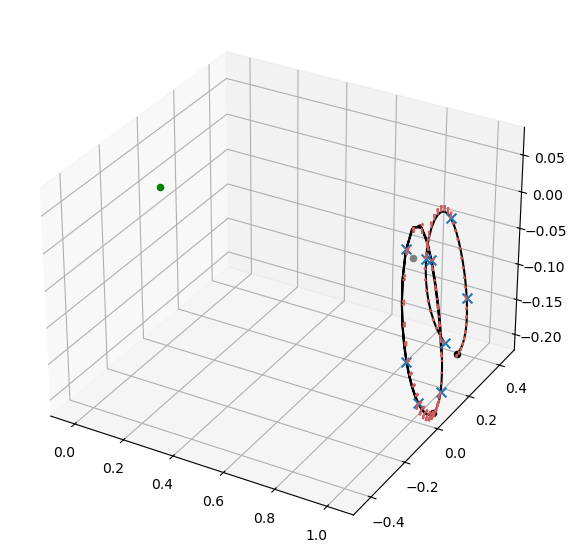

In [396]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Earth and the Moon the boundary states
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
ax.scatter(rs[0], rs[1], rs[2], c="k", s=20)
ax.scatter(rf[0], rf[1], rf[2], c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf, units=1, N=10, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5,
    unit_M=MASS,
)


# Making the axis nicer
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-1/2,1/2)
# ax.view_init(-90,-90)
# ax.axis('off');

(-0.5, 0.5)

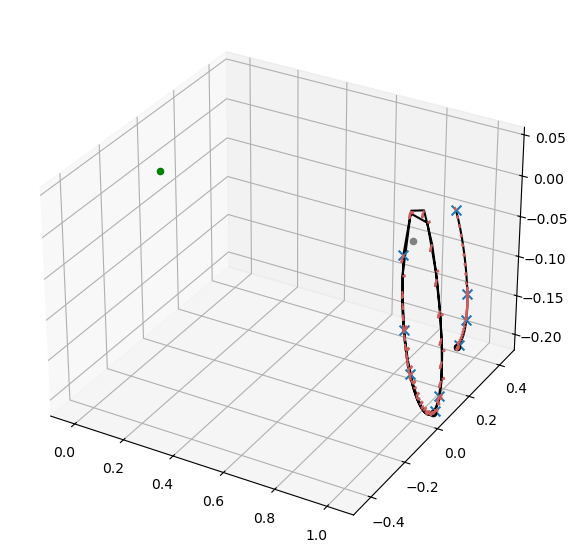

In [397]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Earth and the Moon the boundary states
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
ax.scatter(rs[0], rs[1], rs[2], c="k", s=20)
ax.scatter(rf[0], rf[1], rf[2], c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf_alpha, units=1, N=10, use_alpha=True, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5,
    unit_M=MASS,
)


# Making the axis nicer
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-1/2,1/2)
# ax.view_init(-90,-90)
# ax.axis('off');